In [1]:
from functions import *
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
from pathlib import Path



In [16]:
processRaw = False #  whether to process pupil and gaze from the uncleaned file
saveFiles = False


In [17]:
#read in the mega df
local_username = 'yud070'
pathEL = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_tracker/"
pathpy = "Z:/yueying/psychedeLights_YueyingDong/data/pdRaw_psychopy/"

readIn = sorted([f for f in os.listdir(pathpy)])[-48:-2]


relevantCols = ['RECORDING_SESSION_LABEL','AVERAGE_GAZE_X',
       'AVERAGE_GAZE_Y','AVERAGE_PUPIL_SIZE','EYE_TRACKED','IP_LABEL','IP_START_TIME',
      'LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','SAMPLE_MESSAGE','TIMESTAMP','TRIALID']
pupCols = ['EYE_TRACKED','LEFT_PUPIL_SIZE','RIGHT_PUPIL_SIZE','AVERAGE_PUPIL_SIZE',
           'IP_LABEL','TIMESTAMP','TRIALID']
selectEye = 'AVERAGE_PUPIL_SIZE'
included = 8000


# Load

In [18]:

# Define paths
BASE_PATH = Path("Z:/yueying/psychedeLights_YueyingDong")
PSYCHOPY_PATH = BASE_PATH / "results/data/psychopy"
PUPIL_RAW_PATH = BASE_PATH / "pupRaw_formatted"
PUPIL_CLEAN_PATH = BASE_PATH / "results/data/pupClean"

# Load behavioral data
print("Loading behavioral data...")
psy_files = glob.glob(str(PSYCHOPY_PATH / "psyFull_*.csv"))
psyFull = pd.concat(
    [pd.read_csv(f) for f in psy_files],
    axis=0,
    ignore_index=True
)
print(f"  Loaded {len(psyFull)} trials from {len(psy_files)} files")

if processRaw:
    print("\nLoading raw pupil data for processing...")
    pupil_raw_files = glob.glob(str(PUPIL_RAW_PATH / "*.csv"))
    pupFullTrial_raw = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_raw_files],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(pupFullTrial_raw)} trials from {len(pupil_raw_files)} files")
    
    print("\nProcessing pupil data...")
    pupClean = process_pupil_data_pipeline(pupFullTrial_raw, psyFull,
                                           max_missing_proportion = 0.1)
    
else:
    print("\nLoading pre-processed pupil data...")
    pupil_clean_files = glob.glob(str(PUPIL_CLEAN_PATH / "*.csv"))
    pupClean = pd.concat(
        [pd.read_csv(f).iloc[:, 1:] for f in pupil_clean_files],
        axis=0,
        ignore_index=True
    )
    print(f"  Loaded {len(pupClean)} trials from {len(pupil_clean_files)} files")

print("\n✓ Data loading complete!")

Loading behavioral data...
  Loaded 9924 trials from 3 files

Loading pre-processed pupil data...
  Loaded 9066 trials from 3 files

✓ Data loading complete!


# Handle Psychopy data

In [29]:
# Exclude participants
rejSubj = [254, 250]
psyFull = psyFull[~psyFull['participant'].isin(rejSubj)].reset_index(drop=True)
print(f"Excluded {len(rejSubj)} participants. Remaining trials: {len(psyFull)}")

# Add cued item brightness (left or right based on cued direction)
psyFull['cuedItemBri'] = psyFull.apply(
    lambda row: row['leftBri'] if row['cuedItem'] == 'left' else row['rightBri'],
    axis=1
)

# Calculate correctness (assuming 'rsp' should equal 'cuedItem' for correct trials)
psyFull['correctness'] = np.where(psyFull.rsp !='cuedItem',0,1)

# Log-transform reaction time
psyFull['logRT'] = np.log(psyFull['rt'])

# Map distractor type based on trial type and congruency
# Logic: incongruent trials flip the modality
distractor_mapping = {
    ('congruent', 'verbal'): 'verbal',
    ('incongruent', 'verbal'): 'visual',
    ('congruent', 'visual'): 'visual',
    ('incongruent', 'visual'): 'verbal'
}

psyFull['distractorType_visVer'] = psyFull.apply(
    lambda row: distractor_mapping.get(
        (row['distractorType'], row['trlType']),
        'noDistractor'
    ),
    axis=1
)

Excluded 2 participants. Remaining trials: 9492


In [26]:
psyFull.participant.value_counts()

44

# example trial, post cleaning

In [20]:
events = {'fixation':0,'stim':500,'precueRest':3000,'retrocue':500,'delay':500,}

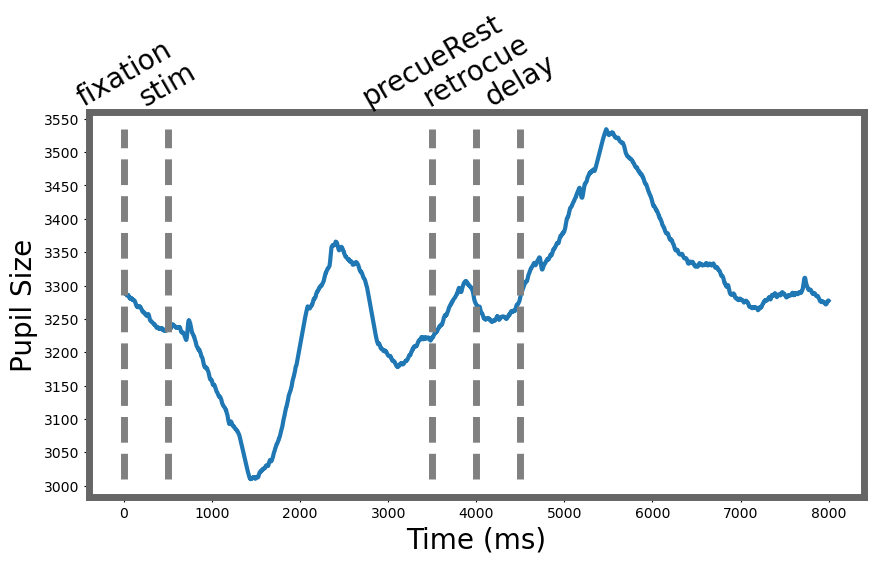

In [21]:
fs(10, 5)
fig, ax = plt.subplots()

eg = 30  # np.random.randint(pupClean.shape[0])
trial_data = pupClean.iloc[eg, 1:].values
timepoints = np.arange(len(trial_data))

# Plot pupil trace
plt.plot(timepoints, trial_data, color='#1f77b4', linewidth=3)

# Event markers
event_times = np.cumsum(list(events.values()))
y_min, y_max = np.nanmin(trial_data), np.nanmax(trial_data)
plt.vlines(event_times, y_min, y_max, 
          linestyles='dashed', colors='grey', linewidth=5)

# Optional: Add event labels
event_names = list(events.keys())
for i, (time, name) in enumerate(zip(event_times, event_names)):
    plt.text(time, y_max * 1.01, name, 
            fontsize=20, ha='center', rotation=30)

# Styling
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Pupil Size', fontsize=20)

ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))

for spine in ax.spines.values():
    spine.set_color('#666666')
    spine.set_linewidth(5)



# Pupil results

In [22]:
cList = ['#ba88e9','#5c1486','#60d062','#1e681f']

In [23]:
pupNorm = pupClean.iloc[:,4001:7501].sub(np.nanmean(pupClean.iloc[:,3801:4001],axis =1,)[:,None],axis = 0)
pupNorm.insert(0,'TRIALID',pupClean.TRIALID)

pupNorm = pupNorm[~(pupNorm.iloc[:,1:3501].isnull().sum(axis =1) > 350)]
pupNorm = pupNorm.merge(psyFull[['participant','trlType','TRIALID','cuedItemBri',]],how = 'inner')
pupNorm = pupNorm[~pupNorm.participant.isin(rejSubj)]

pupNorm.shape[0]/(pupNorm.participant.nunique()*216)

C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_9044\1203143144.py:1: RuntimeWarning: Mean of empty slice
  pupNorm = pupClean.iloc[:,4001:7501].sub(np.nanmean(pupClean.iloc[:,3801:4001],axis =1,)[:,None],axis = 0)


0.9332912457912458

## permutation test

In [14]:
lenData = 3500
x = np.linspace(0,3.5,lenData)

In [ ]:
dataN = 35

a = pupNorm.iloc[:,1:3501]
a.columns = range(a.shape[1])
a = a.groupby(a.columns // 100, axis=1).mean()
dsPup = pd.concat([a,pupNorm[['trlType','cuedItemBri']]],axis = 1)
dsPup_visual = dsPup[dsPup.trlType == 'visual'].reset_index(drop=True)
dsPup_verbal = dsPup[dsPup.trlType == 'verbal'].reset_index(drop=True)


C:\Users\yud070.AD\AppData\Local\Temp\ipykernel_9044\2492039713.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  a = a.groupby(a.columns // 100, axis=1).mean()


### Agg

In [ ]:
dsPup = pd.concat([a,pupNorm[['cuedItemBri']]],axis = 1)

In [13]:
result = cluster_permutation_test(
    data_df=dsPup,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 4 timepoints (indices 13-16), statistic=-33.152
  Largest observed cluster: 4 timepoints (indices 13-16), statistic=-33.152

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -33.152
  Permutation p-value: 0.0216


In [14]:
cluster_pvalues = [
    np.mean(cluster_stat > result['null_distribution'])
    for cluster_stat in [result['observed_stats'][cluster].sum() 
                         for cluster in result['observed_clusters']]
]

cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in result['observed_clusters']]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0598, 0.0092]
Clusters: [(1.3, 1.7000000000000002), (2.3, 3.5)]


In [15]:
pupMean = pupNorm.groupby(['cuedItemBri']).mean(numeric_only=True)
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]

pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

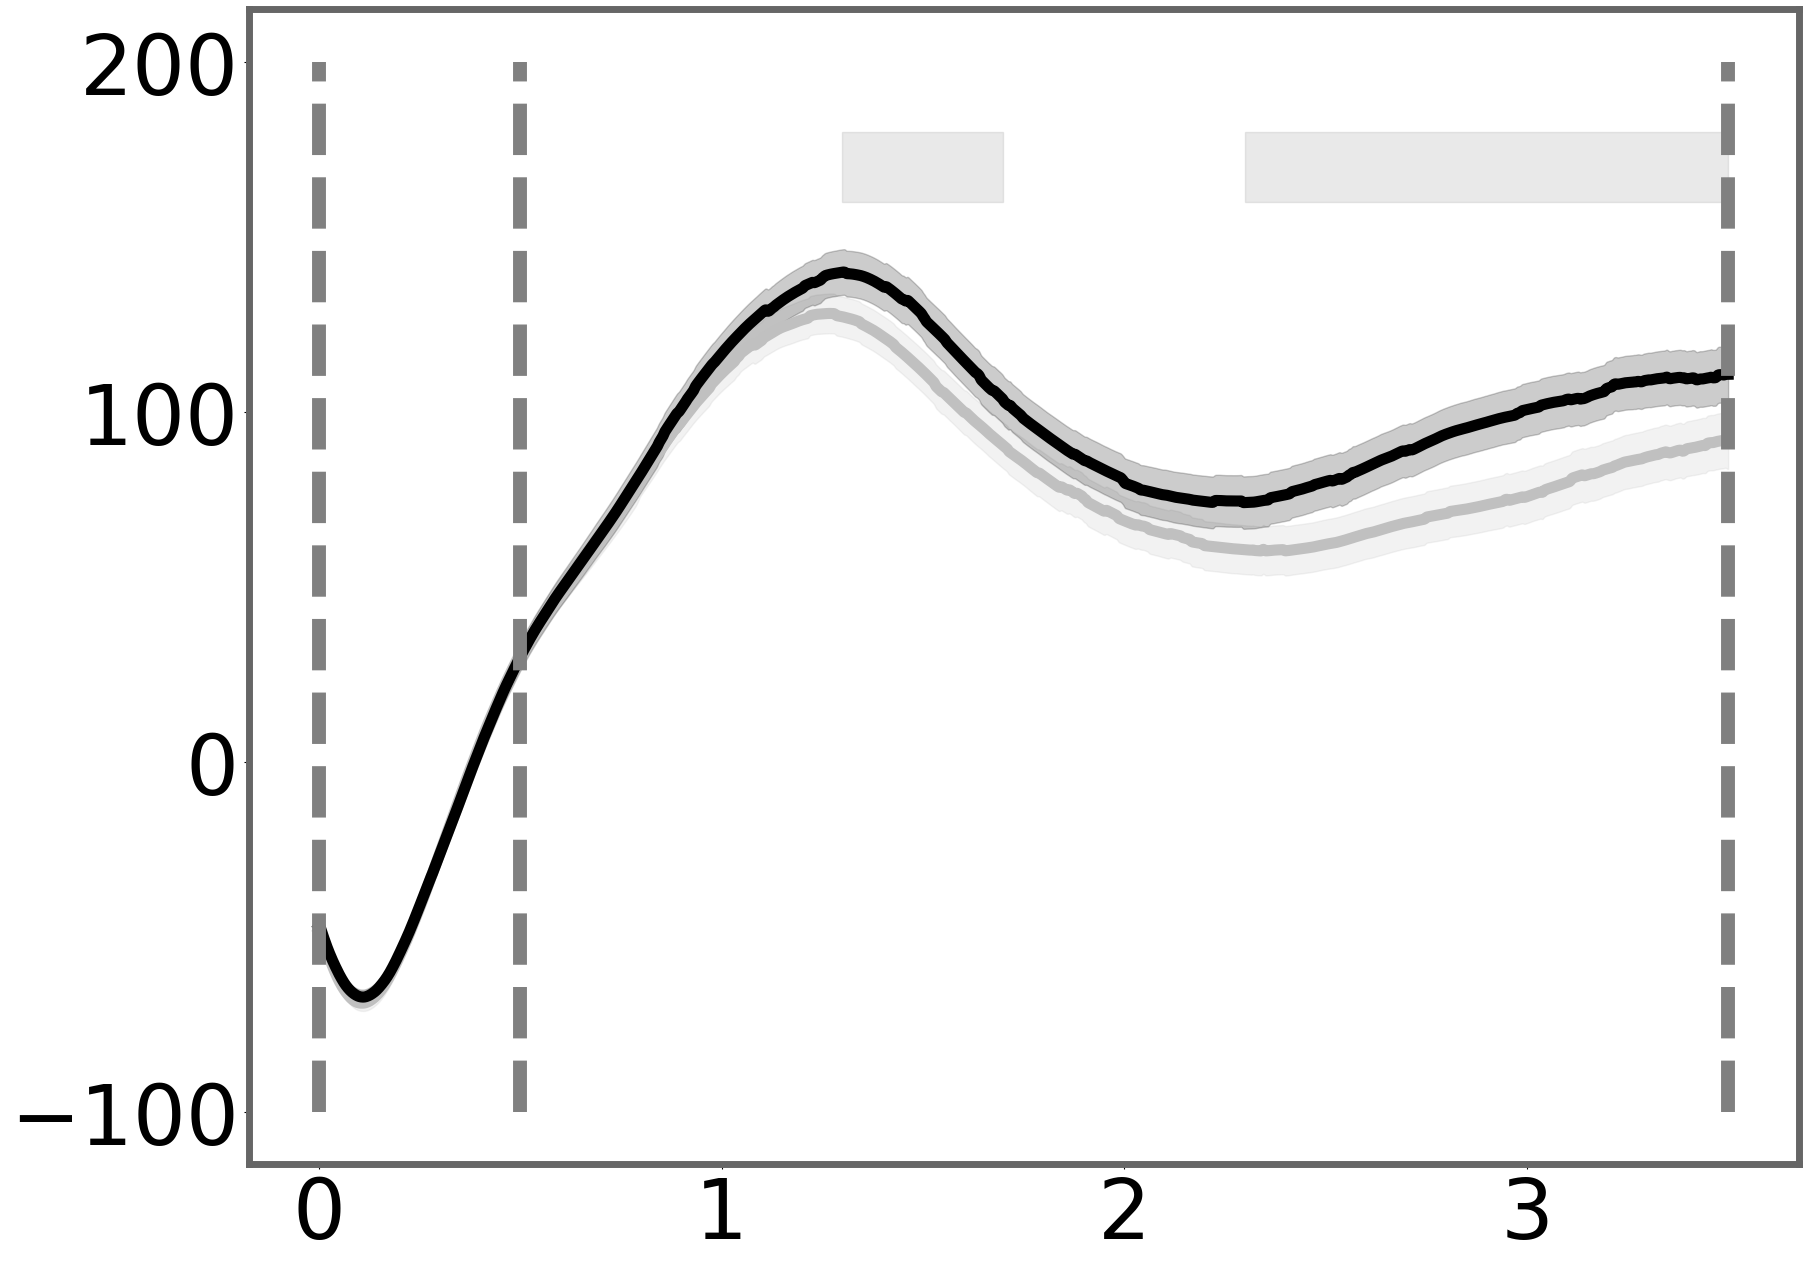

In [16]:
fs(20,15)
fig,ax = plt.subplots()

[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),color = ['silver','black'][i],linewidth = 8) for i in range (2)]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),color =  ['silver','black'][i],alpha = 0.2)for i in range (2)]
plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
[plt.fill_between(i,160,180,color = "#949494",alpha = 0.2) for i in cluster_t]

plt.yticks(fontsize=60)
plt.xticks(fontsize=60)


plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)


### semantic

In [17]:
pupMean = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).mean().iloc[:,:-1]
pupSd = pupNorm.drop(['TRIALID'],axis = 1).groupby(['trlType','cuedItemBri',]).sem().iloc[:,:-1]
pupUpper = pupMean + pupSd
pupLower = pupMean - pupSd

In [18]:
dsPup_verbal

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,trlType,cuedItemBri
0,-30.978929,-46.871548,-45.602976,-39.782024,-37.562500,-27.453452,-24.500334,-31.233646,-40.187500,-33.504881,...,-114.095833,-118.947738,-116.722024,-115.681071,-109.097500,-109.638690,-119.456071,-124.035833,verbal,night
1,-14.013333,-22.862619,-7.731905,24.739762,62.168333,89.727619,111.115952,126.423381,155.106409,172.563186,...,-95.156667,-101.188333,-108.452857,-106.632143,-95.438095,-89.485238,-88.021667,-90.838810,verbal,day
2,-52.676071,-80.962024,-89.039167,-76.564405,-57.175595,-25.448929,8.648690,24.443690,36.097262,25.868452,...,-103.299643,-109.632024,-110.049881,-99.858690,-76.328214,-57.528452,-46.056310,-53.799643,verbal,night
3,-72.440476,-98.452381,-91.766905,-88.168571,-90.305714,-79.807143,-57.705952,-42.179048,-43.379524,-36.755714,...,-131.133333,-130.404048,-133.579524,-131.713095,-125.034524,-111.931667,-94.385476,-82.026905,verbal,night
4,-65.772262,-88.283690,-97.108214,-94.393214,-65.345357,-23.855119,7.258452,23.782738,35.223929,50.447024,...,-68.187976,-71.846071,-74.099405,-76.404167,-74.458214,-70.545833,-68.191071,-64.589643,verbal,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,-268.786925,-375.151687,-465.836211,-573.217396,-671.331909,-761.137183,-844.535816,-923.166056,-993.072193,-1057.359544,...,-1727.354782,-1732.864068,-1742.416211,-1724.322163,-1694.396449,-1624.770258,-1589.283115,-1602.715076,verbal,day
4374,-83.723077,-133.805697,-165.014506,-182.956411,-201.575935,-213.445935,-222.799952,-236.372043,-259.403070,-282.434096,...,-171.855503,-91.496032,13.014303,82.025256,156.087637,259.406684,362.825732,458.969325,verbal,night
4375,-26.226013,-37.786599,-10.922196,-14.148928,-44.638690,-75.807521,-106.823520,-116.994942,-138.246482,-198.743149,...,-186.086720,-201.562196,-199.074815,-180.881244,-146.787434,-111.849815,-72.314339,-50.778625,verbal,day
4376,-5.717619,7.688095,21.063749,32.629902,46.355392,60.080882,73.806373,87.531863,101.257353,114.982843,...,463.035000,464.989524,454.025714,421.420952,381.381934,336.589133,292.422119,252.393414,verbal,night


In [19]:
result_visual = cluster_permutation_test(
    data_df=dsPup_verbal,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  No significant clusters found in observed data


### visual

In [20]:
result_visual = cluster_permutation_test(
    data_df=dsPup_visual,
    condition_column='cuedItemBri',
    condition_values=('day', 'night'),
    n_permutations=5000,
    data_columns=slice(0, 35),  # 35 downsampled bins
    p_threshold=0.05,
    seed=42
)

Running cluster permutation test:
  Conditions: day vs night
  Timepoints: 35
  Permutations: 5000
  P-threshold: 0.05

Computing observed statistics...
  Largest observed cluster: 6 timepoints (indices 12-17), statistic=-32.501
  Largest observed cluster: 6 timepoints (indices 12-17), statistic=-32.501

Running 5000 permutations...
  Progress: 1000/5000
  Progress: 2000/5000
  Progress: 3000/5000
  Progress: 4000/5000
  Progress: 5000/5000

RESULTS:
  Observed largest cluster statistic: -32.501
  Permutation p-value: 0.0248


In [21]:
cluster_pvalues = [
    np.mean(cluster_stat > result_visual['null_distribution'])
    for cluster_stat in [result_visual['observed_stats'][cluster].sum() 
                         for cluster in result_visual['observed_clusters']]
]

cluster_t = [(i[0]/10,i[-1]/10+0.1) #since the array starts at 0, plus 0.1
    for i in result_visual['observed_clusters']]

print("Cluster p-values:", cluster_pvalues)
print("Clusters:", cluster_t)

Cluster p-values: [0.0418, 0.0116]
Clusters: [(1.2, 1.8), (2.3, 3.5)]


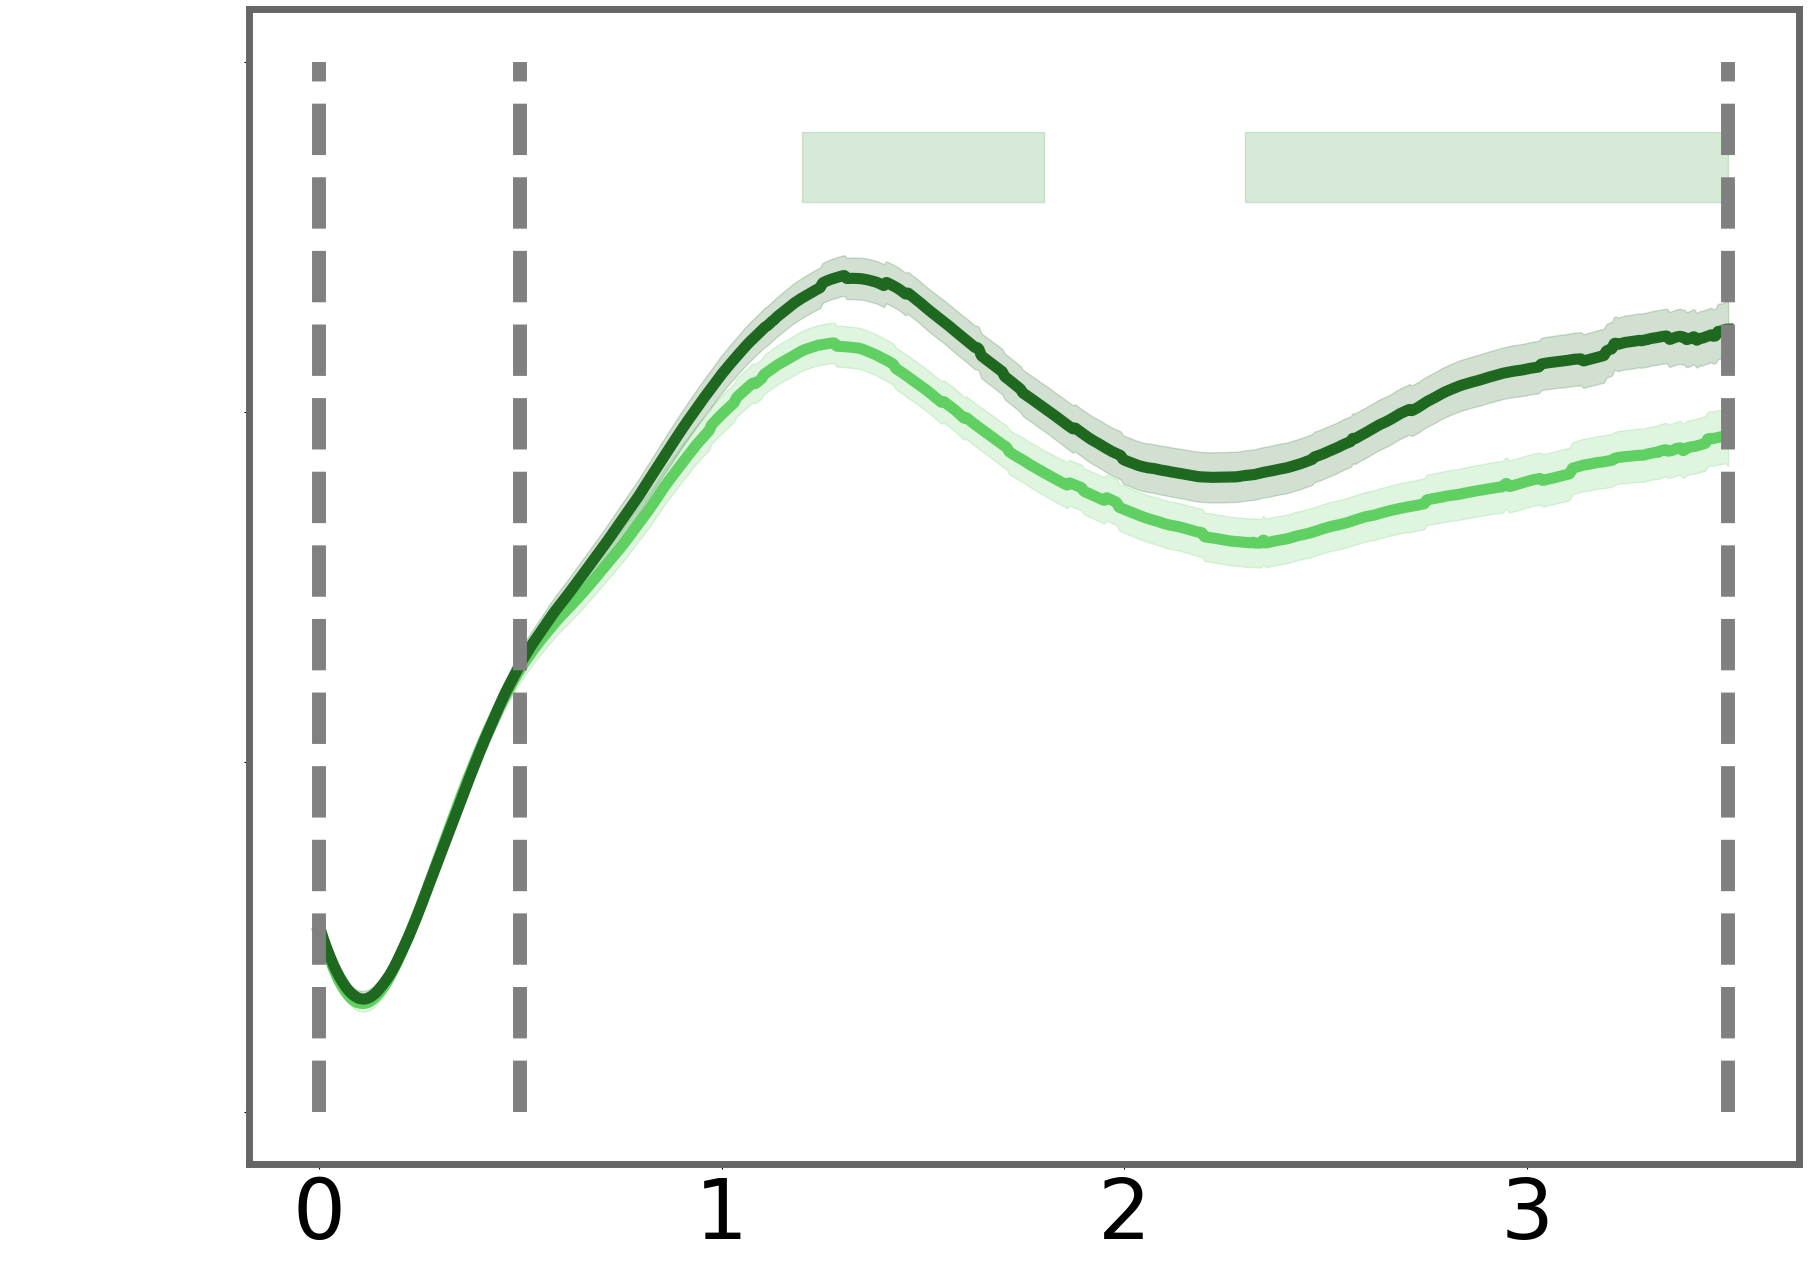

In [22]:
fs(20,15)
fig,ax = plt.subplots()
[plt.plot(x,smooth_signal(pupMean.iloc[i,:lenData],11),c = cList[i],linewidth = 8) for i in [2,3]]
[plt.fill_between(x,smooth_signal(pupUpper.iloc[i,:lenData]),smooth_signal(pupLower.iloc[i,:lenData]),alpha = 0.2,color = cList[i]) for i in [2,3]]
[plt.fill_between(i,160,180,color = "#359937",alpha = 0.2) for i in cluster_t]

plt.vlines([0,0.5,3.5],-100,200,colors='grey',linestyles='dashed',linewidth = 10)
plt.yticks(fontsize=60,c = 'white')
plt.xticks(fontsize=60)

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.subplots_adjust(wspace=0.28)

ax.spines['left'].set_color('#666666')
ax.spines['bottom'].set_color('#666666')
ax.spines['right'].set_color('#666666')
ax.spines['top'].set_color('#666666')
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
ax.spines['right'].set_linewidth(5)
ax.spines['top'].set_linewidth(5)